# Which one is a better plan?

Telecom operator Megaline offers its clients two prepaid plans, Surf and Ultimate. The commercial department wants to know which of the plans brings in more revenue in order to adjust the advertising budget.

Let's carry out a preliminary analysis of the plans based on a relatively small client selection. We have the data on 500 Megaline clients: who the clients are, where they're from, which plan they use, and the number of calls they made and text messages they sent in 2018. We will look at the distributions of call usage, messages sent, internet used and revenue earned by the provider. 

## Initialization

In [94]:
# Loading all the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import re
import math
import seaborn as sns

In [95]:
#Updating to plot histograms with Seaborn.
!pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.2)


## Load data

In [96]:
# Load the data files into different DataFrames
try:
    calls = pd.read_csv('/datasets/megaline_calls.csv')
except:
    print('Unable to load dataset, please check filepath.')

In [97]:
try:
    internet = pd.read_csv('/datasets/megaline_internet.csv')
except:
    print('Unable to load dataset, please check filepath.')

In [98]:
try:
    messages = pd.read_csv('/datasets/megaline_messages.csv')
except:
    print('Unable to load dataset, please check filepath.')

In [99]:
try:
    plans = pd.read_csv('/datasets/megaline_plans.csv')
except:
    print('Unable to load dataset, please check filepath.')

In [100]:
try:
    users = pd.read_csv('/datasets/megaline_users.csv')
except:
    print('Unable to load dataset, please check filepath.')

## Prepare the data

## Plans

In [101]:
# Print the general/summary information about the plans' DataFrame
plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
usd_monthly_pay          2 non-null int64
usd_per_gb               2 non-null int64
usd_per_message          2 non-null float64
usd_per_minute           2 non-null float64
plan_name                2 non-null object
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [102]:
# Print a sample of data for plans
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [103]:
plans['gb_per_month_included'] = plans['mb_per_month_included'] // 1024 

In [104]:
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30


No obvious issues with this data. It is consistent with the brief provided in plan descriptions. Later, we can add columns for GB included as required.

## Users

In [105]:
# Print the general/summary information about the users' DataFrame
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
first_name    500 non-null object
last_name     500 non-null object
age           500 non-null int64
city          500 non-null object
reg_date      500 non-null object
plan          500 non-null object
churn_date    34 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [106]:
# Print a sample of data for users
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN


All columns seem to have accurate data but we will dive deeper and also look at duplicates. The `churn_date` column has missing values. This is likely since users have not churned, hence no date is applicable. We can create a separate churn tracking column with boolean values. Some users seem to continue to use their plans after they have churned. They may have signed back up for the service. We will leave these values as they are.

In [107]:
users.duplicated().sum()

0

No duplicates.

### Fix Data

In [108]:
#Let's look at age:
users['age'].describe()

count    500.000000
mean      45.486000
std       16.972269
min       18.000000
25%       30.000000
50%       46.000000
75%       61.000000
max       75.000000
Name: age, dtype: float64

No obvious issues here.

### Enrich Data

Let's add a `has_churned` column to mark churned customers.

In [109]:
users['has_churned'] = users['churn_date'].fillna(0)
users['has_churned'].where(users['has_churned'] == 0, 1, inplace = True)

In [110]:
users['has_churned'].value_counts()

0    466
1     34
Name: has_churned, dtype: int64

In [111]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')

In [112]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
user_id        500 non-null int64
first_name     500 non-null object
last_name      500 non-null object
age            500 non-null int64
city           500 non-null object
reg_date       500 non-null object
plan           500 non-null object
churn_date     34 non-null datetime64[ns]
has_churned    500 non-null object
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 35.3+ KB


Let's create a column for the state the user is located in. 

In [113]:
users.iloc[22]

user_id                                             1022
first_name                                            Bo
last_name                                           Snow
age                                                   73
city           New York-Newark-Jersey City, NY-NJ-PA MSA
reg_date                                      2018-04-20
plan                                                surf
churn_date                           2018-09-07 00:00:00
has_churned                                            1
Name: 22, dtype: object

In [114]:
#separating into city, state and region type
pattern = r"(?P<city>[\w\s-]+),\s*(?P<state>[\w-]+)\s(?P<region_type>\w+)"
users['city_new'] = users['city'].str.extract(pattern, flags = re.I)['city']
users['state'] = users['city'].str.extract(pattern, flags = re.I)['state']
users['region_type'] = users['city'].str.extract(pattern, flags = re.I)['region_type']

In [115]:
users.drop('city', inplace = True, axis = 1)
users.rename(columns ={'city_new':'city'}, inplace = True)

In [116]:
users

,user_id,first_name,last_name,age,reg_date,plan,churn_date,has_churned,city,state,region_type
0,1000,Anamaria,Bauer,45,2018-12-24,ultimate,NaT,0,Atlanta-Sandy Springs-Roswell,GA,MSA
1,1001,Mickey,Wilkerson,28,2018-08-13,surf,NaT,0,Seattle-Tacoma-Bellevue,WA,MSA
2,1002,Carlee,Hoffman,36,2018-10-21,surf,NaT,0,Las Vegas-Henderson-Paradise,NV,MSA
3,1003,Reynaldo,Jenkins,52,2018-01-28,surf,NaT,0,Tulsa,OK,MSA
4,1004,Leonila,Thompson,40,2018-05-23,surf,NaT,0,Seattle-Tacoma-Bellevue,WA,MSA
...,...,...,...,...,...,...,...,...,...,...,...
495,1495,Fidel,Sharpe,67,2018-09-04,surf,NaT,0,New York-Newark-Jersey City,NY-NJ-PA,MSA
496,1496,Ariel,Shepherd,49,2018-02-20,surf,NaT,0,New Orleans-Metairie,LA,MSA
497,1497,Donte,Barrera,49,2018-12-10,ultimate,NaT,0,Los Angeles-Long Beach-Anaheim,CA,MSA
498,1498,Scot,Williamson,51,2018-02-04,surf,NaT,0,New York-Newark-Jersey City,NY-NJ-PA,MSA


## Calls

In [117]:
# Print the general/summary information about the calls' DataFrame
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null object
duration     137735 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [118]:
# Print a sample of data for calls
calls.head()

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


### Fix data

Let's assign datetime to `call_date`. We may not use this for our analysis but it may become relevant if we want to track by day of the week and so on. 

In [119]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
id           137735 non-null object
user_id      137735 non-null int64
call_date    137735 non-null datetime64[ns]
duration     137735 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.2+ MB


### Enrich data

In [120]:
calls['month'] = calls['call_date'].dt.month

## Messages

In [121]:
# Print the general/summary information about the messages' DataFrame
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [122]:
# Print a sample of data for messages
messages.head()

,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


### Fix data

In [123]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
id              76051 non-null object
user_id         76051 non-null int64
message_date    76051 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.7+ MB


### Enrich data

In [124]:
messages['month'] = messages['message_date'].dt.month

## Internet

In [125]:
# Print the general/summary information about the internet DataFrame
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null object
mb_used         104825 non-null float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [126]:
# Print a sample of data for the internet traffic
internet.head()

,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


### Fix data

In [127]:
internet['session_date'] = pd.to_datetime(internet['session_date'],format = '%Y-%m-%d')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
id              104825 non-null object
user_id         104825 non-null int64
session_date    104825 non-null datetime64[ns]
mb_used         104825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 3.2+ MB


### Enrich data

In [128]:
internet['month'] = internet['session_date'].dt.month

## Study plan conditions

In [129]:
# Print out the plan conditions for reference

**Plan Conditions**

Surf:
* Monthly charge: $20
* 500 monthly minutes, 50 texts, and 15 GB of data

After exceeding the package limits:
* 1 minute: 3 cents
* 1 text message: 3 cents
* 1 GB of data: $10

Ultimate:
* Monthly charge: $70
* 3000 monthly minutes, 1000 text messages, and 30 GB of data

After exceeding the package limits:
* 1 minute: 1 cent
* 1 text message: 1 cent
* 1 GB of data: $7

## Aggregate data per user

In [130]:
# Calculate the number of calls made by each user per month.
call_count_pivot = calls.pivot_table(index = ['user_id','month'], values = 'id', aggfunc = 'count')
call_count_pivot.rename(columns = {'id':'call_count'},inplace = True)

In [131]:
# Calculate the amount of minutes spent by each user per month. 
call_duration = calls.pivot_table(index = ['user_id','month'], values = 'duration', aggfunc = 'sum')
call_duration['duration'] = call_duration['duration'].apply(math.ceil)
call_duration

duration
user_id month          
1000    12          117
1001    8           172
        9           298
        10          375
        11          405
...                 ...
1498    12          325
1499    9           331
        10          364
        11          289
        12          469

[2258 rows x 1 columns]

In [132]:
# Calculate the number of messages sent by each user per month.
message_count_pivot = messages.pivot_table(index = ['user_id','month'], values = 'id', aggfunc = 'count')
message_count_pivot.rename(columns = {'id':'message_count'},inplace = True)

In [133]:
# Calculate the volume of internet traffic used by each user per month.
internet_pivot = internet.pivot_table(index = ['user_id','month'], values = 'mb_used', aggfunc = 'sum')
internet_pivot

mb_used
user_id month          
1000    12      1901.47
1001    8       6919.15
        9      13314.82
        10     22330.49
        11     18504.30
...                 ...
1498    12     23137.69
1499    9      12984.76
        10     19492.43
        11     16813.83
        12     22059.21

[2277 rows x 1 columns]

In [134]:
# Merging the data for calls, minutes, messages, internet based on user_id and month
user_data = call_count_pivot.join([call_duration,message_count_pivot,internet_pivot], how = 'outer')

In [135]:
user_data

call_count  duration  message_count   mb_used
user_id month                                               
1000    12           16.0     117.0           11.0   1901.47
1001    8            27.0     172.0           30.0   6919.15
        9            49.0     298.0           44.0  13314.82
        10           65.0     375.0           53.0  22330.49
        11           64.0     405.0           36.0  18504.30
...                   ...       ...            ...       ...
1498    12           39.0     325.0            NaN  23137.69
1499    9            41.0     331.0            NaN  12984.76
        10           53.0     364.0            NaN  19492.43
        11           45.0     289.0            NaN  16813.83
        12           65.0     469.0            NaN  22059.21

[2293 rows x 4 columns]

In [136]:
users.set_index('user_id',inplace = True)

In [137]:
user_data = user_data.reset_index().merge(users['plan'], on = 'user_id').set_index(['user_id','month'])

In [138]:
user_data

call_count  duration  message_count   mb_used      plan
user_id month                                                         
1000    12           16.0     117.0           11.0   1901.47  ultimate
1001    8            27.0     172.0           30.0   6919.15      surf
        9            49.0     298.0           44.0  13314.82      surf
        10           65.0     375.0           53.0  22330.49      surf
        11           64.0     405.0           36.0  18504.30      surf
...                   ...       ...            ...       ...       ...
1498    12           39.0     325.0            NaN  23137.69      surf
1499    9            41.0     331.0            NaN  12984.76      surf
        10           53.0     364.0            NaN  19492.43      surf
        11           45.0     289.0            NaN  16813.83      surf
        12           65.0     469.0            NaN  22059.21      surf

[2293 rows x 5 columns]

Since NaN values likely indicate no messages sent, we can safely coerce them to 0

In [139]:
user_data['message_count'].fillna(0, inplace = True)

In [140]:
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30


In [141]:
plans['gb_per_month_included'] = plans['mb_per_month_included'] // 1024 # 1024MB to a GB

In [142]:
plans

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included
0,50,15360,500,20,10,0.03,0.03,surf,15
1,1000,30720,3000,70,7,0.01,0.01,ultimate,30


In [143]:
user_data = user_data.reset_index().merge(plans, left_on = 'plan', right_on='plan_name').set_index(['user_id','month'])

In [144]:
user_data.drop('plan_name', axis = 1,inplace = True)

In [145]:
user_data

call_count  duration  message_count   mb_used      plan  \
user_id month                                                            
1000    12           16.0     117.0           11.0   1901.47  ultimate   
1006    11            2.0      10.0           15.0   2068.37  ultimate   
        12            9.0      55.0          139.0  32118.82  ultimate   
1008    10           71.0     451.0           21.0  17106.99  ultimate   
        11           63.0     423.0           37.0  23676.72  ultimate   
...                   ...       ...            ...       ...       ...   
1498    12           39.0     325.0            0.0  23137.69      surf   
1499    9            41.0     331.0            0.0  12984.76      surf   
        10           53.0     364.0            0.0  19492.43      surf   
        11           45.0     289.0            0.0  16813.83      surf   
        12           65.0     469.0            0.0  22059.21      surf   

               messages_included  mb_per_month_included  minutes_included  \
user_id month                                                               
1000    12                  1000                  30720              3000   
1006    11                  1000                  30720              3000   
        12                  1000                  30720              3000   
1008    10                  1000                  30720              3000   
        11                  1000                  30720              3000   
...                          ...                    ...               ...   
1498    12                    50                  15360               500   
1499    9                     50                  15360               500   
        10                    50                  15360               500   
        11                    50                  15360               500   
        12                    50                  15360               500   

               usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute  \
user_id month                                                                 
1000    12                  70           7             0.01            0.01   
1006    11                  70           7             0.01            0.01   
        12                  70           7             0.01            0.01   
1008    10                  70           7             0.01            0.01   
        11                  70           7             0.01            0.01   
...                        ...         ...              ...             ...   
1498    12                  20          10             0.03            0.03   
1499    9                   20          10             0.03            0.03   
        10                  20          10             0.03            0.03   
        11                  20          10             0.03            0.03   
        12                  20          10             0.03            0.03   

               gb_per_month_included  
user_id month                         
1000    12                        30  
1006    11                        30  
        12                        30  
1008    10                        30  
        11                        30  
...                              ...  
1498    12                        15  
1499    9                         15  
        10                        15  
        11                        15  
        12                        15  

[2293 rows x 13 columns]

In [146]:
surf_data = user_data.query('plan == "surf"')
ultimate_data = user_data.query('plan == "ultimate"')

## Study user behaviour

### Calls

Observing Individual Trends:

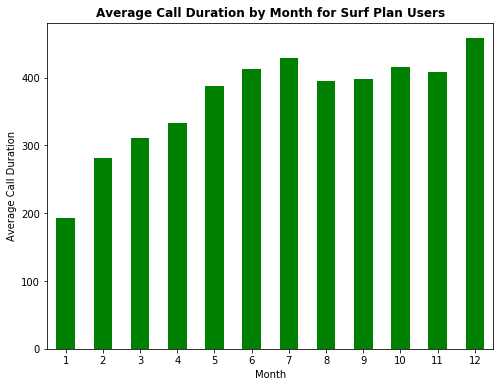

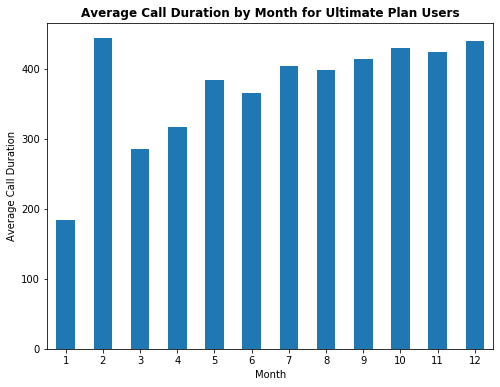

In [147]:
surf_data.groupby(['plan','month'])['duration'].agg('mean').plot(kind='bar', figsize =(8,6), color = 'green', rot = 0)
x_pos = np.arange(12)
plt.xticks(x_pos, [1,2,3,4,5,6,7,8,9,10,11,12])
plt.ylabel('Average Call Duration')
plt.xlabel('Month')
plt.title('Average Call Duration by Month for Surf Plan Users', weight = 'bold')
plt.show()

ultimate_data.groupby(['plan','month'])['duration'].agg('mean').plot(kind='bar', figsize =(8,6),rot = 0)
plt.xticks(x_pos, [1,2,3,4,5,6,7,8,9,10,11,12])
plt.ylabel('Average Call Duration')
plt.xlabel('Month')
plt.title('Average Call Duration by Month for Ultimate Plan Users', weight = 'bold')
plt.show()

Observing Trends Comparatively:

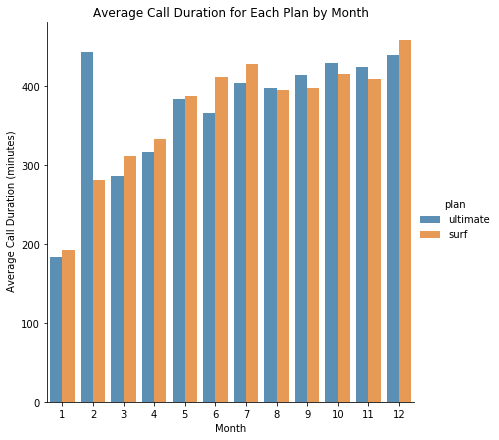

In [148]:
sns.catplot(data=user_data.reset_index(), kind='bar', x = 'month', y = 'duration', hue = 'plan', alpha = 0.8, height = 6, ci = None)
plt.ylabel(' Average Call Duration (minutes)')
plt.xlabel('Month')
plt.title('Average Call Duration for Each Plan by Month')
plt.show()

Comparing Distributions

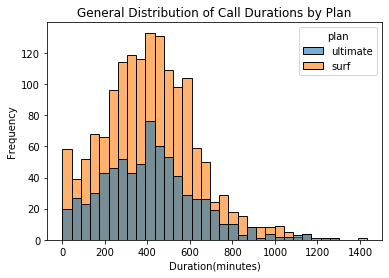

In [149]:
sns.histplot(data = user_data.reset_index(), x = 'duration',hue='plan', alpha = 0.6)
plt.xlabel('Duration(minutes)')
plt.ylabel('Frequency')
plt.title('General Distribution of Call Durations by Plan')
plt.show()

Calculate the mean and variance of call durations.

In [150]:
mean_surf_duration = surf_data.groupby('month')['duration'].agg('mean').mean()
var_surf_duration = np.var(surf_data.groupby('month')['duration'].agg('mean'))

mean_ultimate_duration = ultimate_data.groupby('month')['duration'].agg('mean').mean()
var_ultimate_duration = np.var(ultimate_data.groupby('month')['duration'].agg('mean'))

print(f'The average minutes used per month by Surf plan users are: {mean_surf_duration:.2f} minutes and the variance is {var_surf_duration:.2f}.')
print(f'The average minutes used per month by Ultimate plan users are: {mean_ultimate_duration:.2f} minutes and the variance is {var_ultimate_duration:.2f}.')

The average minutes used per month by Surf plan users are: 368.43 minutes and the variance is 5177.03.
The average minutes used per month by Ultimate plan users are: 374.19 minutes and the variance is 5430.68.


Comparing Boxplots

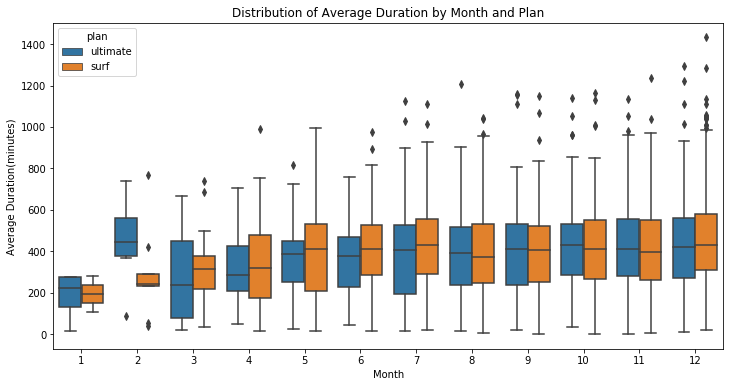

In [151]:
fig,ax = plt.subplots(figsize = (12,6))
sns.boxplot(data = user_data.reset_index(), x = 'month', y = 'duration', hue = 'plan')
plt.xlabel('Month')
plt.ylabel('Average Duration(minutes)')
plt.title('Distribution of Average Duration by Month and Plan')
plt.show()

**Observations:**

1. The distribution of mean call durations per month does not vary significantly between plans. Users tend to have a median time around 400 minutes per month regardless of the plan. 
2. Mean Call duration in January is approximately half the call duration other months.
3. Mean Call duration for Ultimate plan users spikes in February while it is much lower for Surf plan users. 
4. Surf plan users display significant outliers during the month of December. This could indicate increased call frequency for the holiday season(i.e. Christmas and New Year's)
5. The distributions for both plan users are quite similar. We can verify this using statistical tests down the line.

### Messages

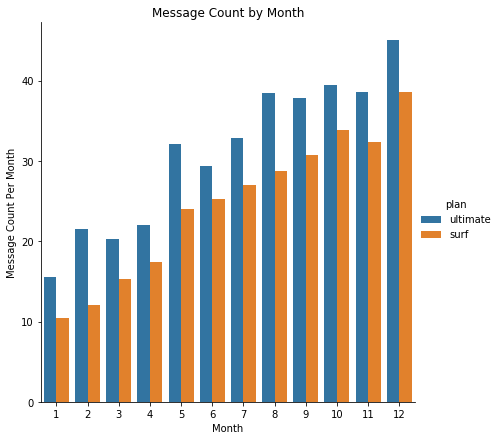

In [152]:
sns.catplot(data = user_data.reset_index(), kind = 'bar', x = 'month', y = 'message_count', hue = 'plan', height = 6, ci = None)
plt.xlabel('Month')
plt.ylabel('Message Count Per Month')
plt.title('Message Count by Month')
plt.show()

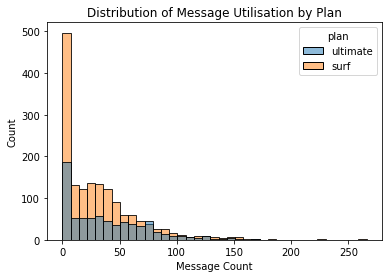

In [153]:
sns.histplot(data = user_data.reset_index(), x = 'message_count', hue = 'plan')
plt.xlabel('Message Count')
plt.ylabel('Count')
plt.title('Distribution of Message Utilisation by Plan');

**Observations:**

1. Ultimate plan users tend to use more messages than Surf plan users.
2. Number of messages used tends to increase towards the end of the month. This is not necessarily a trend but likely due to an addition of users to the network as the year progresses.
3. The distribution for Ultimate plan is skewed further right than for Surf plan.

### Internet

In [154]:
user_data[user_data['mb_used'] == 0].shape[0]

0

No need to handle exceptions for 0 data usage in a month

In [155]:
#Add a column for gb used.
user_data['gb_used'] = user_data['mb_used'] // 1024 + 1

In [156]:
user_data

call_count  duration  message_count   mb_used      plan  \
user_id month                                                            
1000    12           16.0     117.0           11.0   1901.47  ultimate   
1006    11            2.0      10.0           15.0   2068.37  ultimate   
        12            9.0      55.0          139.0  32118.82  ultimate   
1008    10           71.0     451.0           21.0  17106.99  ultimate   
        11           63.0     423.0           37.0  23676.72  ultimate   
...                   ...       ...            ...       ...       ...   
1498    12           39.0     325.0            0.0  23137.69      surf   
1499    9            41.0     331.0            0.0  12984.76      surf   
        10           53.0     364.0            0.0  19492.43      surf   
        11           45.0     289.0            0.0  16813.83      surf   
        12           65.0     469.0            0.0  22059.21      surf   

               messages_included  mb_per_month_included  minutes_included  \
user_id month                                                               
1000    12                  1000                  30720              3000   
1006    11                  1000                  30720              3000   
        12                  1000                  30720              3000   
1008    10                  1000                  30720              3000   
        11                  1000                  30720              3000   
...                          ...                    ...               ...   
1498    12                    50                  15360               500   
1499    9                     50                  15360               500   
        10                    50                  15360               500   
        11                    50                  15360               500   
        12                    50                  15360               500   

               usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute  \
user_id month                                                                 
1000    12                  70           7             0.01            0.01   
1006    11                  70           7             0.01            0.01   
        12                  70           7             0.01            0.01   
1008    10                  70           7             0.01            0.01   
        11                  70           7             0.01            0.01   
...                        ...         ...              ...             ...   
1498    12                  20          10             0.03            0.03   
1499    9                   20          10             0.03            0.03   
        10                  20          10             0.03            0.03   
        11                  20          10             0.03            0.03   
        12                  20          10             0.03            0.03   

               gb_per_month_included  gb_used  
user_id month                                  
1000    12                        30      2.0  
1006    11                        30      3.0  
        12                        30     32.0  
1008    10                        30     17.0  
        11                        30     24.0  
...                              ...      ...  
1498    12                        15     23.0  
1499    9                         15     13.0  
        10                        15     20.0  
        11                        15     17.0  
        12                        15     22.0  

[2293 rows x 14 columns]

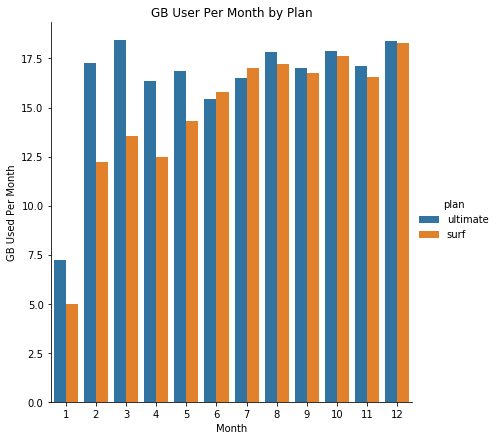

In [157]:
sns.catplot(data = user_data.reset_index(), kind = 'bar', x = 'month', y = 'gb_used', hue = 'plan', ci = None, height = 6)
plt.xlabel('Month')
plt.ylabel('GB Used Per Month')
plt.title('GB User Per Month by Plan');

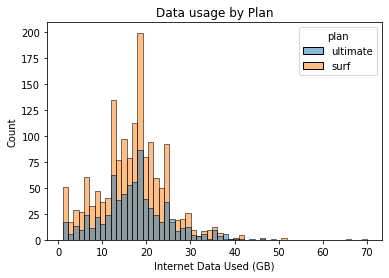

In [158]:
sns.histplot(data = user_data.reset_index(), x = 'gb_used', hue = 'plan')
plt.ylabel('Count')
plt.xlabel('Internet Data Used (GB)')
plt.title('Data usage by Plan');

**Observations:**
1. The internet data usage for Ultimate plan users is generally higher.
2. The distribution of data usage is similar for both plans.

## Revenue

[Likewise you have studied the user behaviour, statistically describe the revenue between the plans.]

In [159]:
user_data['message_exceeded'] = user_data['message_count'] - user_data['messages_included']

In [160]:
user_data['message_exceeded'] = user_data['message_exceeded'].where(user_data['message_exceeded'] > 0, 0)

In [161]:
user_data['duration_exceeded'] = user_data['duration'] - user_data['minutes_included']

In [162]:
user_data['duration_exceeded'] = user_data['duration_exceeded'].where(user_data['duration_exceeded'] > 0,0)

In [163]:
user_data['duration_exceeded'].value_counts()

0.0      1809
72.0        6
112.0       6
106.0       6
169.0       6
         ... 
140.0       1
289.0       1
147.0       1
459.0       1
647.0       1
Name: duration_exceeded, Length: 263, dtype: int64

In [164]:
user_data['internet_exceeded'] = user_data['gb_used'] - user_data['gb_per_month_included']

In [165]:
user_data['internet_exceeded'] = user_data['internet_exceeded'].where(user_data['internet_exceeded'] >0,0)

In [166]:
user_data['internet_exceeded'].value_counts()

0.0     1341
3.0      120
2.0      116
6.0       99
4.0       86
1.0       84
5.0       84
7.0       63
8.0       56
9.0       52
10.0      42
13.0      20
12.0      20
11.0      17
14.0      16
16.0      11
15.0      11
19.0       9
18.0       8
22.0       7
20.0       6
21.0       6
17.0       4
26.0       3
27.0       2
36.0       2
25.0       2
51.0       1
23.0       1
34.0       1
24.0       1
31.0       1
55.0       1
Name: internet_exceeded, dtype: int64

Let's calculate revenue by adding monthly cost and added expenses based on usage.

In [167]:
user_data['revenue'] = user_data['usd_monthly_pay'] + (user_data['message_exceeded'] * user_data['usd_per_message']) + (user_data['duration_exceeded']+ user_data['usd_per_minute']) + (user_data['internet_exceeded'] * user_data['usd_per_gb'])
                                                                                                         

In [168]:
user_data

call_count  duration  message_count   mb_used      plan  \
user_id month                                                            
1000    12           16.0     117.0           11.0   1901.47  ultimate   
1006    11            2.0      10.0           15.0   2068.37  ultimate   
        12            9.0      55.0          139.0  32118.82  ultimate   
1008    10           71.0     451.0           21.0  17106.99  ultimate   
        11           63.0     423.0           37.0  23676.72  ultimate   
...                   ...       ...            ...       ...       ...   
1498    12           39.0     325.0            0.0  23137.69      surf   
1499    9            41.0     331.0            0.0  12984.76      surf   
        10           53.0     364.0            0.0  19492.43      surf   
        11           45.0     289.0            0.0  16813.83      surf   
        12           65.0     469.0            0.0  22059.21      surf   

               messages_included  mb_per_month_included  minutes_included  \
user_id month                                                               
1000    12                  1000                  30720              3000   
1006    11                  1000                  30720              3000   
        12                  1000                  30720              3000   
1008    10                  1000                  30720              3000   
        11                  1000                  30720              3000   
...                          ...                    ...               ...   
1498    12                    50                  15360               500   
1499    9                     50                  15360               500   
        10                    50                  15360               500   
        11                    50                  15360               500   
        12                    50                  15360               500   

               usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute  \
user_id month                                                                 
1000    12                  70           7             0.01            0.01   
1006    11                  70           7             0.01            0.01   
        12                  70           7             0.01            0.01   
1008    10                  70           7             0.01            0.01   
        11                  70           7             0.01            0.01   
...                        ...         ...              ...             ...   
1498    12                  20          10             0.03            0.03   
1499    9                   20          10             0.03            0.03   
        10                  20          10             0.03            0.03   
        11                  20          10             0.03            0.03   
        12                  20          10             0.03            0.03   

               gb_per_month_included  gb_used  message_exceeded  \
user_id month                                                     
1000    12                        30      2.0               0.0   
1006    11                        30      3.0               0.0   
        12                        30     32.0               0.0   
1008    10                        30     17.0               0.0   
        11                        30     24.0               0.0   
...                              ...      ...               ...   
1498    12                        15     23.0               0.0   
1499    9                         15     13.0               0.0   
        10                        15     20.0               0.0   
        11                        15     17.0               0.0   
        12                        15     22.0               0.0   

               duration_exceeded  internet_exceeded  revenue  
user_id month                                                 
1000    12              

[Formulate conclusions about how the revenue differs between the plans.]

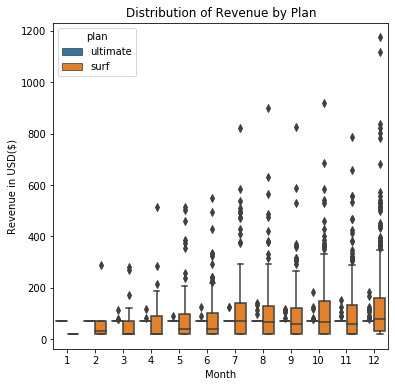

In [169]:
fig,ax = plt.subplots(figsize = (6,6))
sns.boxplot(data = user_data.reset_index(), x ='month', y = 'revenue', hue = 'plan')
plt.xlabel('Month')
plt.ylabel('Revenue in USD($)')
plt.title('Distribution of Revenue by Plan')
plt.show()

It is quite evident that users on the surf plan have significantly varied monthly bills. Let's plot a histogram to confirm

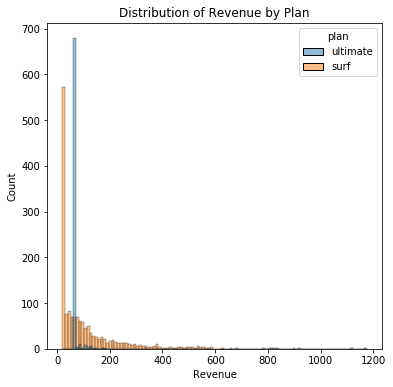

In [170]:
fig,ax = plt.subplots(figsize = (6,6))
sns.histplot(data= user_data.reset_index(), x='revenue', hue = 'plan')
plt.xlabel('Revenue')
plt.ylabel('Count')
plt.title('Distribution of Revenue by Plan');

This solidifies our theory that Surf plan has an extremely varied distribution while the Ultimate plan is concentrated around a value. Let's analyze separately and look at standard deviations.

In [171]:
surf_data = user_data.query('plan == "surf"')
ultimate_data = user_data.query('plan =="ultimate"')

count    1573.000000
mean      107.869116
std       131.826897
min        20.030000
25%        20.030000
50%        60.030000
75%       130.030000
max      1174.280000
Name: revenue, dtype: float64

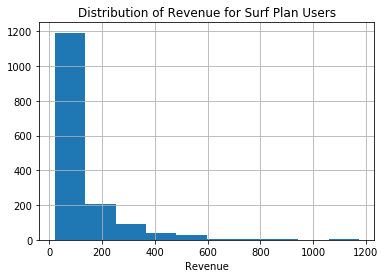

In [172]:
surf_data.hist(column = 'revenue')
plt.xlabel('Revenue')
plt.title('Distribution of Revenue for Surf Plan Users');
surf_data['revenue'].describe()

In [173]:
surf_data['revenue'].describe()['std'] / surf_data['revenue'].describe()['mean'] * 100

122.21004638151713

count    720.000000
mean      72.323889
std       11.395108
min       70.010000
25%       70.010000
50%       70.010000
75%       70.010000
max      182.010000
Name: revenue, dtype: float64

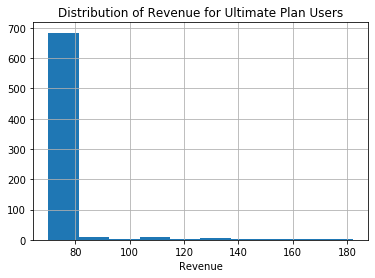

In [174]:
ultimate_data.hist(column = 'revenue')
plt.xlabel('Revenue')
plt.title('Distribution of Revenue for Ultimate Plan Users');
ultimate_data['revenue'].describe()

In [175]:
ultimate_data['revenue'].describe()['std'] / ultimate_data['revenue'].describe()['mean'] * 100

15.755662673571672

**Observations:**

1. Ultimate Plan revenue has a very concentrated distribution. The mean and median are quite close and the standard deviation is relatively low at 15% with respect to the mean. 

2. Surf plan users has a very varied distribution with significant outliers and a standard deviation of 122% with respect to the mean.

3. We cannot yet answer if these differences are statistically significant. Let's test them.

## Test statistical hypotheses

Let's test the first set of hypotheses:

* Ho - There is no significant difference between the average revenue generated by users on Surf and Ultimate Plans.

* H1 - An average user on the Surf plan is likely to pay more for their subscription as compared to a user of the Ultimate Plan.

For accuracy, we will take alpha = 0.01 for a one-sided t-test.

In [176]:
# Test the hypotheses
surf_data_revenue = surf_data['revenue']
ultimate_data_revenue = ultimate_data['revenue']

alpha = 0.01

results = st.ttest_ind(surf_data_revenue,ultimate_data_revenue, equal_var = False)
print(f'P-value:{results.pvalue / 2}')

if results.pvalue / 2 < alpha and surf_data_revenue.mean() > ultimate_data_revenue.mean():
    print('We reject the null hypothesis, Ho.')
    print('H1 is likely to be accurate.')
else:
    print('We cannot reject Ho')
    print('H1 is likely to be false ')

P-value:9.147771701795772e-26
We reject the null hypothesis, Ho.
H1 is likely to be accurate.


We succesfully reject the  null hypothesis

We have 2 hypotheses: 

* Ho - There is no significant difference in average revenue of users between users in NY-NJ region and other regions.

* H1 - The average revenue earned from users in NY-NJ region differs significantly from revenue earned from users from other regions. 

In [177]:
users

,first_name,last_name,age,reg_date,plan,churn_date,has_churned,city,state,region_type
user_id,,,,,,,,,,
1000,Anamaria,Bauer,45,2018-12-24,ultimate,NaT,0,Atlanta-Sandy Springs-Roswell,GA,MSA
1001,Mickey,Wilkerson,28,2018-08-13,surf,NaT,0,Seattle-Tacoma-Bellevue,WA,MSA
1002,Carlee,Hoffman,36,2018-10-21,surf,NaT,0,Las Vegas-Henderson-Paradise,NV,MSA
1003,Reynaldo,Jenkins,52,2018-01-28,surf,NaT,0,Tulsa,OK,MSA
1004,Leonila,Thompson,40,2018-05-23,surf,NaT,0,Seattle-Tacoma-Bellevue,WA,MSA
...,...,...,...,...,...,...,...,...,...,...
1495,Fidel,Sharpe,67,2018-09-04,surf,NaT,0,New York-Newark-Jersey City,NY-NJ-PA,MSA
1496,Ariel,Shepherd,49,2018-02-20,surf,NaT,0,New Orleans-Metairie,LA,MSA
1497,Donte,Barrera,49,2018-12-10,ultimate,NaT,0,Los Angeles-Long Beach-Anaheim,CA,MSA


In [178]:
user_data = user_data.reset_index().merge(users[['city','state']], on='user_id').set_index(['user_id','month'])

In [179]:
user_data

call_count  duration  message_count   mb_used      plan  \
user_id month                                                            
1000    12           16.0     117.0           11.0   1901.47  ultimate   
1006    11            2.0      10.0           15.0   2068.37  ultimate   
        12            9.0      55.0          139.0  32118.82  ultimate   
1008    10           71.0     451.0           21.0  17106.99  ultimate   
        11           63.0     423.0           37.0  23676.72  ultimate   
...                   ...       ...            ...       ...       ...   
1498    12           39.0     325.0            0.0  23137.69      surf   
1499    9            41.0     331.0            0.0  12984.76      surf   
        10           53.0     364.0            0.0  19492.43      surf   
        11           45.0     289.0            0.0  16813.83      surf   
        12           65.0     469.0            0.0  22059.21      surf   

               messages_included  mb_per_month_included  minutes_included  \
user_id month                                                               
1000    12                  1000                  30720              3000   
1006    11                  1000                  30720              3000   
        12                  1000                  30720              3000   
1008    10                  1000                  30720              3000   
        11                  1000                  30720              3000   
...                          ...                    ...               ...   
1498    12                    50                  15360               500   
1499    9                     50                  15360               500   
        10                    50                  15360               500   
        11                    50                  15360               500   
        12                    50                  15360               500   

               usd_monthly_pay  usd_per_gb  usd_per_message  usd_per_minute  \
user_id month                                                                 
1000    12                  70           7             0.01            0.01   
1006    11                  70           7             0.01            0.01   
        12                  70           7             0.01            0.01   
1008    10                  70           7             0.01            0.01   
        11                  70           7             0.01            0.01   
...                        ...         ...              ...             ...   
1498    12                  20          10             0.03            0.03   
1499    9                   20          10             0.03            0.03   
        10                  20          10             0.03            0.03   
        11                  20          10             0.03            0.03   
        12                  20          10             0.03            0.03   

               gb_per_month_included  gb_used  message_exceeded  \
user_id month                                                     
1000    12                        30      2.0               0.0   
1006    11                        30      3.0               0.0   
        12                        30     32.0               0.0   
1008    10                        30     17.0               0.0   
        11                        30     24.0               0.0   
...                              ...      ...               ...   
1498    12                        15     23.0               0.0   
1499    9                         15     13.0               0.0   
        10                        15     20.0               0.0   
        11                        15     17.0               0.0   
        12                        15     22.0               0.0   

               duration_exceeded  internet_exceeded  revenue  \
user_id month                                                  
1000    12            

In [180]:
nynj_revenue_data = user_data.query('state == "NY-NJ-PA"')['revenue']
other_revenue_data = user_data.query('state != "NY-NJ-PA"')['revenue']

In [181]:
nynj_revenue_data.describe()

count    377.000000
mean      93.274456
std       96.876727
min       20.030000
25%       20.030000
50%       70.010000
75%      111.030000
max      820.470000
Name: revenue, dtype: float64

In [182]:
np.var(nynj_revenue_data)

9360.206093139332

In [183]:
other_revenue_data.describe()

count    1916.000000
mean       97.383533
std       113.114076
min        20.030000
25%        40.030000
50%        70.010000
75%        93.725000
max      1174.280000
Name: revenue, dtype: float64

In [184]:
np.var(other_revenue_data)

12788.116400406505

In [185]:
results = st.ttest_ind(other_revenue_data,nynj_revenue_data,equal_var = False)
results.pvalue
alpha = 0.05
if results.pvalue < alpha:
    print('We can reject Ho')
else:
    print('We cannot reject Ho')

We cannot reject Ho


We conclude that there is no significant difference between revenue earned from NY-NJ and other regions.

## General conclusion

### Users Behaviour:

#### Calls:

1. The distribution of mean call durations per month does not vary significantly between plans. Users tend to have a median time around 400 minutes per month regardless of the plan. 
2. Mean Call duration in January is approximately half the call duration other months.
3. Mean Call duration for Ultimate plan users spikes in February while it is much lower for Surf plan users. 
4. Surf plan users display significant outliers during the month of December. This could indicate increased call frequency for the holiday season(i.e. Christmas and New Year's)
5. The distributions for both plan users are quite similar. We can verify this using statistical tests down the line.

#### Messages: 

1. Ultimate plan users tend to use more messages than Surf plan users.
2. Number of messages used tends to increase towards the end of the month. This is not necessarily a trend but likely due to an addition of users to the network as the year progresses.
3. The distribution for Ultimate plan is skewed further right than for Surf plan.

#### Internet:

1. The internet data usage for Ultimate plan users is generally higher.
2. The distribution of data usage is similar for both plans.

### Revenue:

1. Ultimate Plan revenue has a very concentrated distribution. The mean and median are quite close and the standard deviation is relatively low at 15% with respect to the mean. 

2. Surf plan users has a very varied distribution with significant outliers and a standard deviation of 122% with respect to the mean.

3. We further statistically test these theories.

### Statistical Tests:

#### Revenue by Plan:

The first set of hypotheses are meant to test differences between revenue generated by users on Surf and Ultimate: 

* Ho - There is no significant difference between the average revenue generated by users on Surf and Ultimate Plans.

* H1 - An average user on the Surf plan is likely to pay more for their subscription as compared to a user of the Ultimate Plan.

**The test rejected Ho. Users on Surf Plan earn more revenue for the provider.**

#### Revenue by Region:

The second test of hypotheses are meant to test differences between revenue generated by users in NY-NJ region and other regions.

* Ho - There is no significant difference in average revenue of users between users in NY-NJ region and other regions.

* H1 - The average revenue earned from users in NY-NJ region differs significantly from revenue earned from users from other regions. 

**Ho could not be rejected. No significant differences exist between users in NY-NJ region and other regions.**